In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from mod_my_utils.read_write_data import *

In [ ]:
class ROC:
    def __init__(self, period=80, buy_threshold=-0.2, sell_threshold= 0.2, folder_path = 'data/',stock_name = 'AMD', index_col = 'Date'):
        self.period=period
        self.buy_threshold=buy_threshold
        self.sell_threshold= sell_threshold
        self.folder_path = folder_path
        self.stock_name = stock_name
        self.index_col = index_col


    def read_data(self):
        stock_data = get_price_csv(folder_name= self.folder_path, symbol= self.stock_name, index_col= self.index_col)
        data = stock_data[["Adj. Close"]].copy()
        data.columns = ["price"]
        return data

    def roc(self, data):
        data['change'] = data['price'].diff(self.period)
        data['shift'] = data['price'].shift(self.period)
        data['roc'] = data['change']/data['shift']
        #data.plot()
        return data

    def generate_signals(self, data):
        #buy_threshold= - 0.2
        #sell_threshold = 0.2
        signals = pd.DataFrame(index= data.index)
        signals['price']=data['price']
        signals['roc']=data['roc']
        signals['b']=0
        signals['s']=0
        signals['b'] = np.where(data['roc']<self.buy_threshold,-1,0)
        signals['s'] = np.where(data['roc']>self.sell_threshold,1,0)

        signals['buy']= signals['b'].diff()
        signals['sell']=signals['s'].diff()


        signals.loc[signals['buy']==-1.0,['buy']] = 0.0
        signals.loc[signals['sell']== 1.0,['sell']] = 0.0
        signals['buy_sell'] = signals['buy'] + signals['sell']
        #signals.buy_sell.plot()
        return signals

    def plot_roc(self, signals):
        graph = plt.figure(figsize=(12,8))
        ax1=graph.add_subplot(311)
        ax2=graph.add_subplot(312)
        ax1.axhline(y=self.sell_threshold,color='m', lw=3)
        ax1.axhline(y= self.buy_threshold,color='y', lw=3)
        signals['roc'].plot(ax=ax1, color='g',title='ROC' )

        ax1.plot(signals.loc[signals.buy_sell == 1].index, signals.roc[signals.buy_sell == 1], "^", markersize = 12, color = "b")
        ax1.plot(signals.loc[signals.buy_sell ==-1].index, signals.roc[signals.buy_sell ==-1], "v", markersize = 12, color = "m")

        signals["price"].plot(ax = ax2)
        ax2.plot(signals.loc[signals.buy_sell == 1].index, signals.price[signals.buy_sell == 1], "^", markersize = 12, color = "b")
        ax2.plot(signals.loc[signals.buy_sell ==-1].index, signals.price[signals.buy_sell ==-1], "v", markersize = 12, color = "m")
        plt.show()


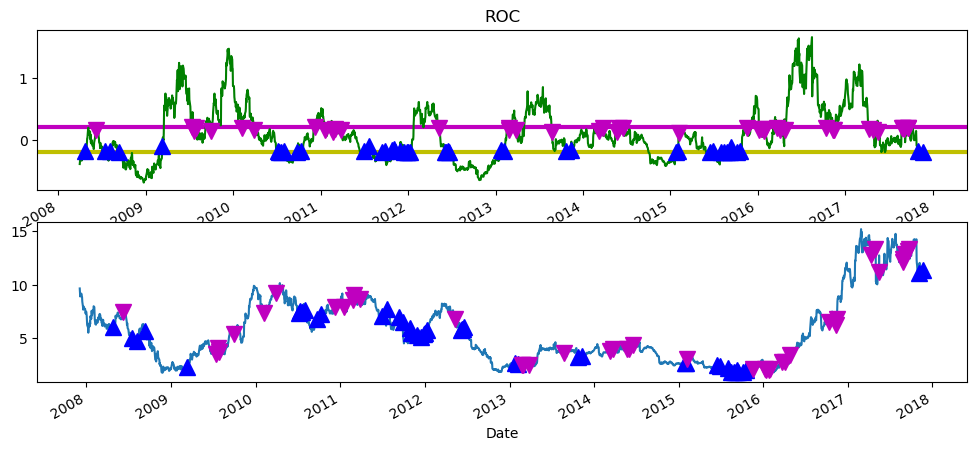

In [ ]:
# Without optimisation

roc= ROC()

stockdata= roc.read_data()
calculate_roc=roc.roc(stockdata)
signals=roc.generate_signals(calculate_roc)
roc.plot_roc(signals)


In [ ]:
def optimize_parameters():
        # Define the parameter ranges for optimization
        periods = [40,80, 120, 100]
        buy_thresholds = [-0.2]
        sell_thresholds = [0.2]


        best_return = -np.inf
        best_params = None

        for period in periods:
            for buy_threshold in buy_thresholds:
                for sell_threshold in sell_thresholds:
                    # Instantiate the class with the current parameters
                    roc= ROC(period=period, buy_threshold=buy_threshold, sell_threshold=sell_threshold)

                    # Fetch historical price data
                    data1 = roc.read_data()


                    # Calculate ROC and buy/sell signals
                    data2 = roc.roc(data1)
                    signals = roc.generate_signals(data2)

                    # Calculate the total return using the buy/sell signals
                    total_return = calculate_total_return(signals)

                    # Update the best parameters if a better return is found
                    if total_return > best_return:
                        best_return = total_return
                        best_period = period
                        best_buy_threshold= buy_threshold
                        best_sell_threshold= sell_threshold

        return best_period, best_buy_threshold, best_sell_threshold, best_return

def calculate_total_return(signals):
    if signals.empty or signals['buy_sell'].sum() == 0:
        return 1.0  # Return 1.0 if no buy/sell signals or the signals DataFrame is empty.

        # Simulate the trading strategy based on buy/sell signals and historical price data
        # For this example, we will assume a simple buy-and-hold strategy using the 'Adj. Close' price.

    signals['position'] = signals['buy_sell'].cumsum()
    signals['returns'] = signals['price'].pct_change() * signals['position'].shift()
    total_return = (signals['returns'] + 1).cumprod()[-1]
    return total_return

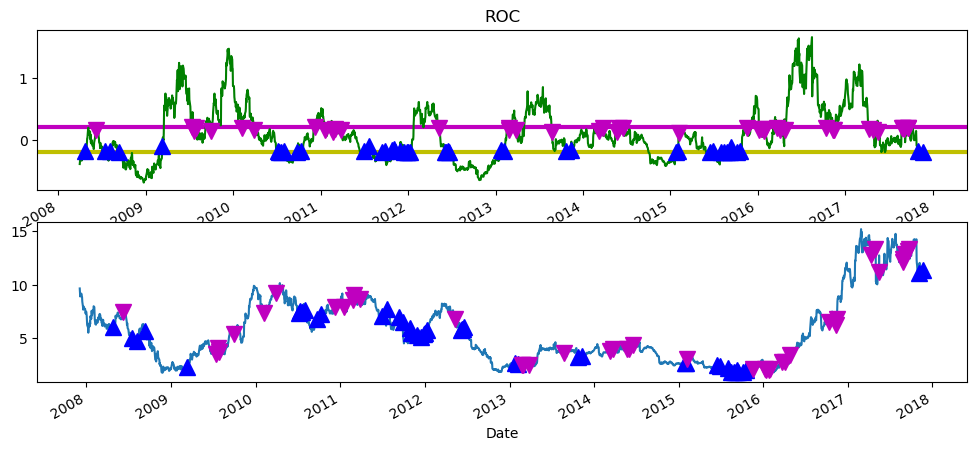

Best Parameters: 
Best period:  120 
Best buy threshold =  -0.2 
Best sell_threshold=  0.2
Best Return: 3.9657630949047055e-11


In [ ]:
best_period, best_buy_threshold, best_sell_threshold, best_return  =  optimize_parameters()

roc= ROC()

data1 = roc.read_data()

data2 = roc.roc(data1)
signals = roc.generate_signals(data2)
roc.plot_roc(signals)


print("Best Parameters: \nBest period: ", best_period, '\nBest buy threshold = ', best_buy_threshold, '\nBest sell_threshold= ', best_sell_threshold)
print("Best Return:", best_return)